In [141]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format='retina'

import sys
sys.path.append("../")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
from decipher_model import DecipherConfig
from decipher_training import train_simple

from post_analysis import (
    rotate_decipher_space,
    cluster_representations,
    compute_trajectories,
    gene_patterns_from_decipher_trajectory,
)
from post_analysis_plotting import plot_decipher_v, plot_trajectory

# from load_data import load_datasets, t_test_deg, MARKER_GENES, palette_original

import numpy as np
import matplotlib.pyplot as plt
import torch

import scanpy as sc
import pandas as pd
from scipy.sparse import csr_matrix

In [144]:
sc.settings.set_figure_params(dpi_save=1200, vector_friendly=True, fontsize=18)
plt.rcParams['axes.grid'] = False
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [145]:
adata = sc.read("data/gastric_data.h5")

adata = adata[~((adata.obs["cellType"] == "dropped"))]

In [ ]:
seed = 0
batch_size = 256
learning_rate = 1e-2

cvi_config = DecipherConfig(
    latent_dim=10,
    pre_latent_dim=2,
    prior="normal",
    z_to_x_layers=[],
    seed=seed,
    context=[],
    beta=1e-1,
)

model,_ = train_simple(
    adata,
    cvi_config,
    learning_rate=learning_rate,
    batch_size=batch_size,
    n_epochs=31,
    plot_every_k_epoch=5,
    plot_kwargs=dict(
        color=[
            "type",
            "type2",
            "class",
            "class_I",
            "class_D",
            "origin",
            "log1p_total_counts",
            "cellType",
        ],
        ncols=2,
    ),
)

In [147]:
adata.obs["align"] = adata.obs["class_D_number"].apply(lambda x: x if x in [1,2,3] else np.nan)
rotate_decipher_space(
    adata, "align", decipher_component_to_align_label_with=1, flip_latent_z=True
)

In [148]:
gastric_palette = {
    "Enteroendo": "#8c564b",
    "D1": "#1f77b4",
    "I1": "#1f77b4",
    "D2": "#ff7f0e",
    "I2": "#ff7f0e",
    "D3": "#2ca02c",
    "I3": "#2ca02c",
    "D4": "#d62728",
    "I4": "#d62728",
    "D5": "#9467bd",
}

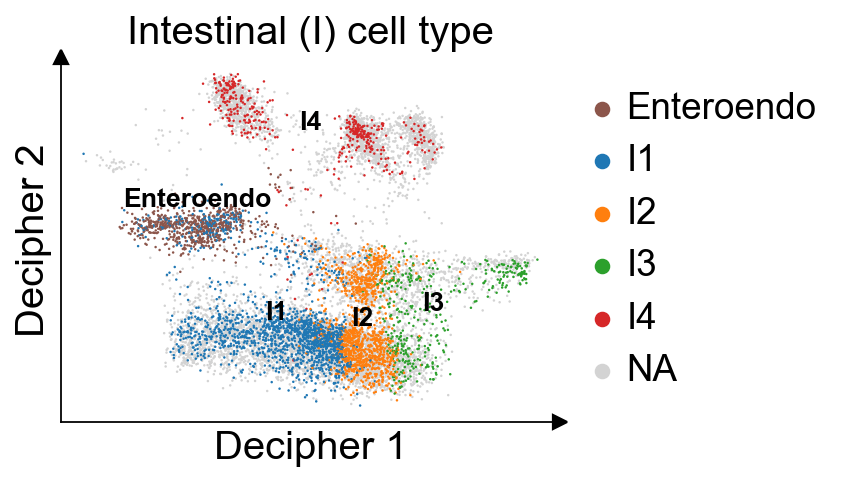

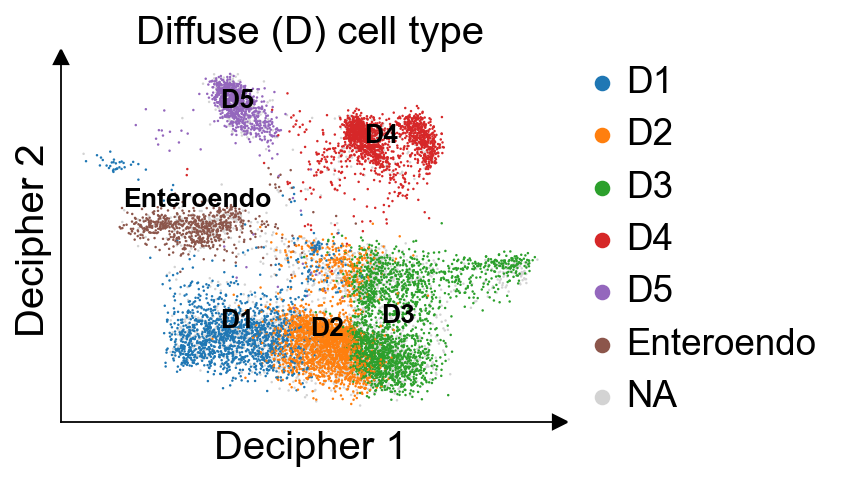

In [149]:
col = "class_I"
fig = plot_decipher_v(
    adata,
    col,
    figsize=(4, 3),
    title="Intestinal (I) cell type",
    size=5,
    palette=gastric_palette,
)
ax = fig.axes[0]
for val in adata.obs[col].unique():
    if type(val) != str:
        continue
    centroid = adata.obsm["decipher_v_corrected"][adata.obs[col] == val].mean(axis=0)
    if val == "Enteroendo":
        centroid[1]+=0.3
    ax.text(*centroid, s=val, fontweight="heavy", fontsize=12, ha="center")
    
plt.savefig("figures/figure5/gastric.type_I.pdf", bbox_inches="tight")

col = "class_D"
fig = plot_decipher_v(
    adata,
    col,
    figsize=(4, 3),
    title="Diffuse (D) cell type",
    size=5,
    palette=gastric_palette,
)
ax = fig.axes[0]
for val in adata.obs[col].unique():
    if type(val) != str:
        continue
    centroid = adata.obsm["decipher_v_corrected"][adata.obs[col] == val].mean(axis=0)
    if val == "Enteroendo":
        centroid[1]+=0.3
    ax.text(*centroid, s=val, fontweight="heavy", fontsize=12, ha="center")
plt.savefig("figures/figure5/gastric.type_D.pdf", bbox_inches="tight")

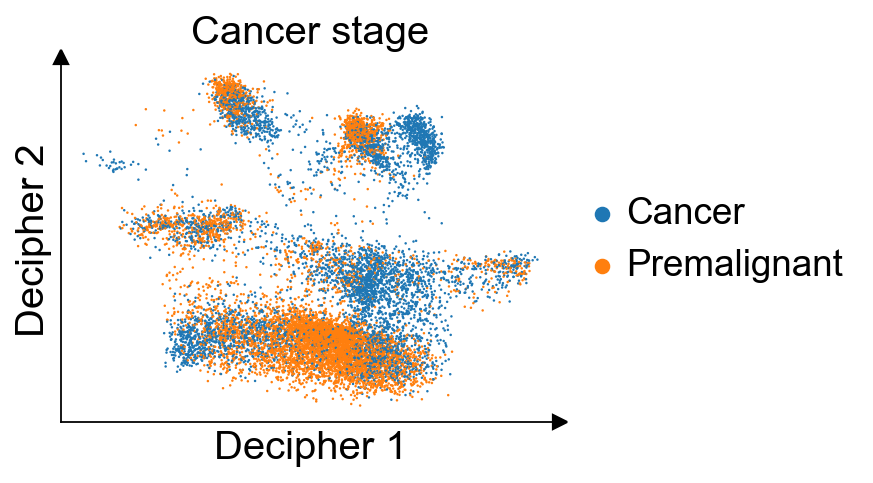

In [150]:
col = "type2"
fig = plot_decipher_v(
    adata,
    col,
    figsize=(4, 3),
    title="Cancer stage",
    size=5,

)

plt.savefig("figures/figure5/gastric.cancer_stage.pdf", bbox_inches="tight")

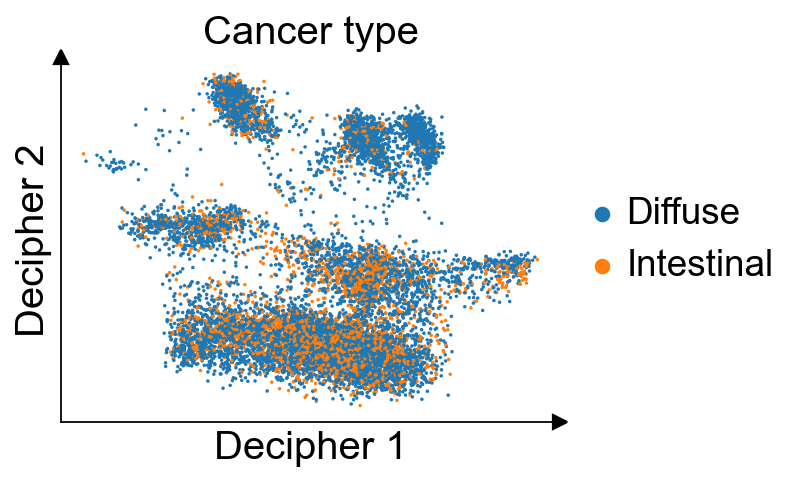

In [151]:
col = "type"
fig = plot_decipher_v(
    adata,
    col,
    figsize=(4, 3),
    title="Cancer type",
    size=10,
)

plt.savefig("figures/figure5/gastric.cancer_type.pdf", bbox_inches="tight")

In [152]:
cluster_representations(adata, leiden_resolution=0.5)

In [153]:
trajectory = compute_trajectories(adata, "HEPACAM2", "MUC13", cell_types_key="class" )

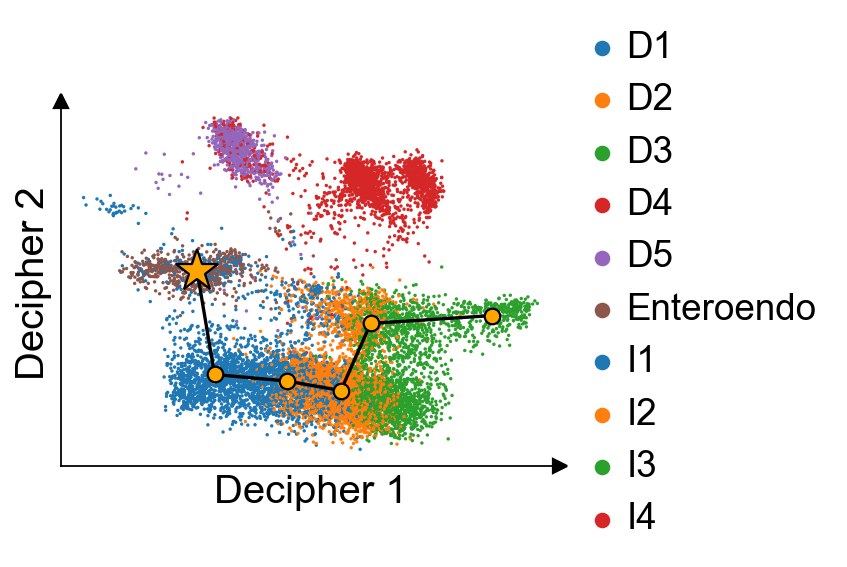

In [155]:
fig = plot_decipher_v(
    adata,
    "class",
    palette=gastric_palette,
    vmax=lambda x: np.quantile(x, 0.95),
    figsize=(4, 3),
    sort_order=False,
)
plot_trajectory(adata, "all_cells", "orange", fig.axes[0])
fig.savefig("figures/figure5/gastric.trajectory.pdf", bbox_inches="tight")

In [120]:
sc.tl.rank_genes_groups(adata, 'class_I', method='t-test', key_added = "t-test")
adata.uns["t-test"]["names"]

rec.array([('HEPACAM2', 'RPS4Y1', 'SNRPG', 'S100A6', 'VIM'),
           ('MS4A8', 'CLU', 'DBI', 'SDCBP2', 'A2M'),
           ('QDPR', 'LYZ', 'UQCRH', 'FXYD3', 'IFITM2'), ...,
           ('TSPO', 'VIM', 'CALD1', 'CALD1', 'SPINT2'),
           ('C19orf33', 'IFITM3', 'VIM', 'LYZ', 'KRT8'),
           ('CTSE', 'XIST', 'XIST', 'VIM', 'SMIM22')],
          dtype=[('Enteroendo', 'O'), ('I1', 'O'), ('I2', 'O'), ('I3', 'O'), ('I4', 'O')])

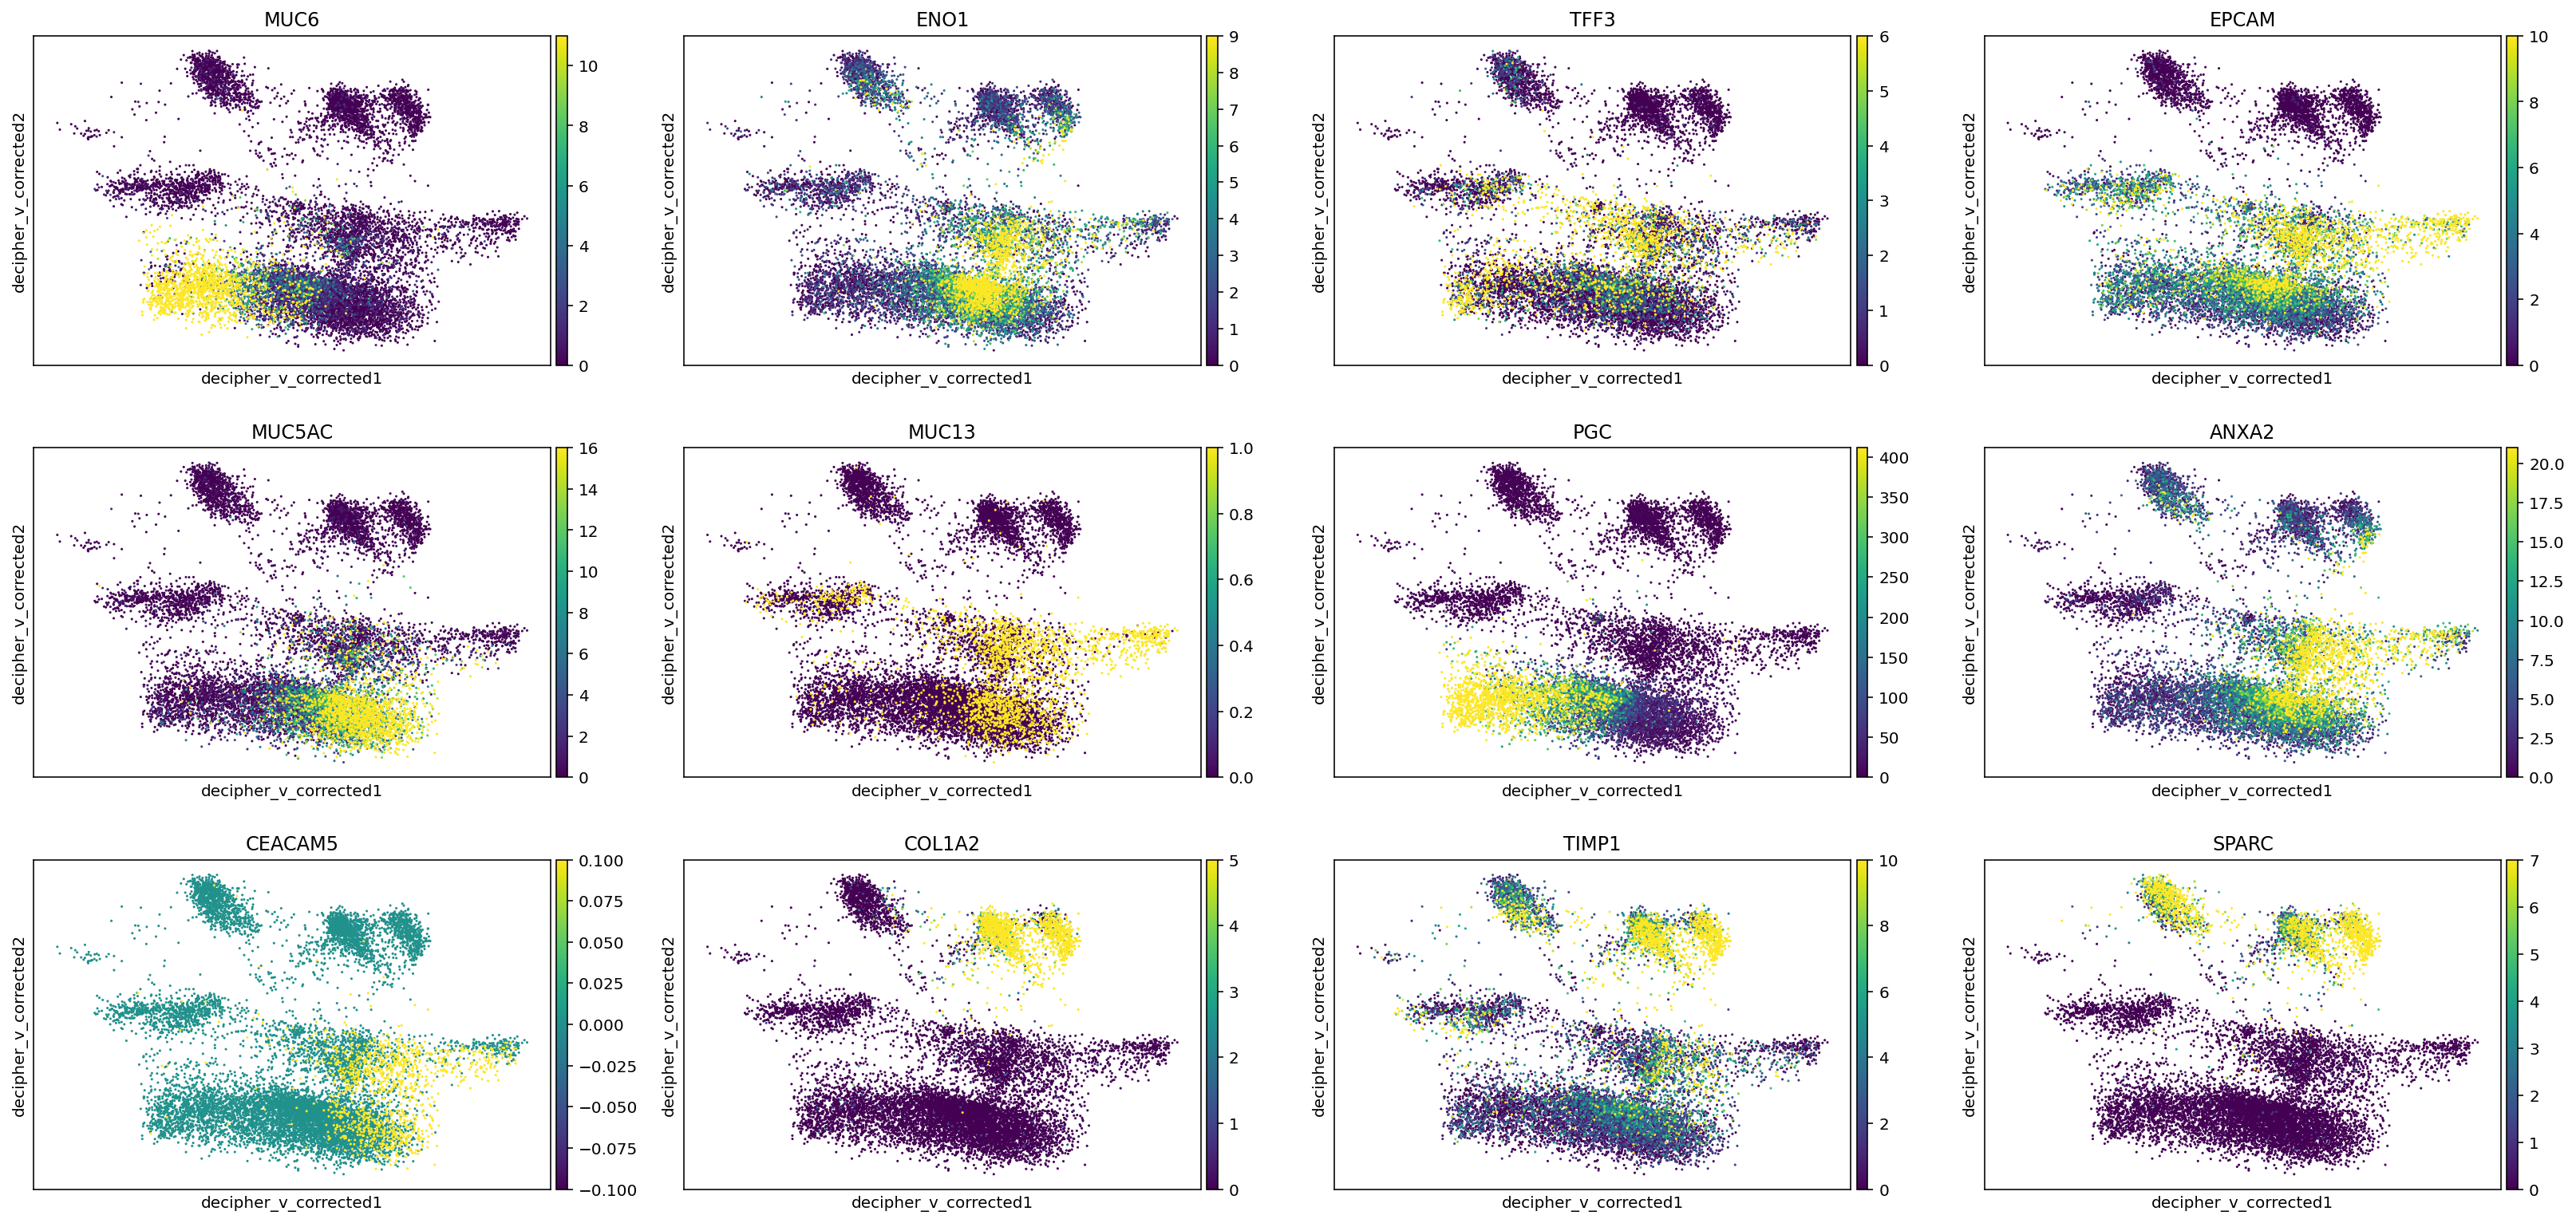

In [121]:
marker_genes = [
    "MUC6", "ENO1", "TFF3", "EPCAM", "MUC5AC",  "MUC13",
    "PGC", "ANXA2", "CEACAM5", "COL1A2", "TIMP1", "SPARC"
]

sc.pl.embedding(
    adata,
    "decipher_v_corrected",
    color=marker_genes,
    vmax=lambda x: np.quantile(x, 0.9),
)

In [122]:
n_samples = 100
gene_patterns = sample_from_decipher_trajectory(
    adata, model, trajectory.trajectory_latent, n_samples=n_samples, smooth=0
)

In [123]:
from post_analysis_plotting import plot_gene_patterns, add_cell_type_band

In [124]:
marker_genes = [
    "MUC6", "ENO1", "TFF3", "EPCAM", "MUC5AC",  "MUC13",
    "PGC", "ANXA2", "CEACAM5", "COL1A2", "TIMP1", "SPARC"
]

In [134]:
def moving_average(x, w):
    if len(x.shape) == 2:
        return np.stack([moving_average(xx, w) for xx in x])
    return np.convolve(x, np.ones(w), "valid") / w

In [137]:
moving_average(gene_patterns[:,:,0], 5)

array([[0.09004167, 0.04486559, 0.05607098, ..., 0.00203449, 0.00088209,
        0.00067985],
       [0.05458988, 0.04103821, 0.03182376, ..., 0.00344342, 0.00281897,
        0.00272317],
       [0.09920665, 0.11504497, 0.11272832, ..., 0.00211764, 0.00203587,
        0.00102486],
       ...,
       [0.29613096, 0.15938852, 0.18293418, ..., 0.00215495, 0.00151524,
        0.00268685],
       [0.24907936, 0.21948467, 0.24711208, ..., 0.00299344, 0.00239742,
        0.00253154],
       [0.13167575, 0.15397932, 0.20359366, ..., 0.00233772, 0.00071102,
        0.00111548]])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


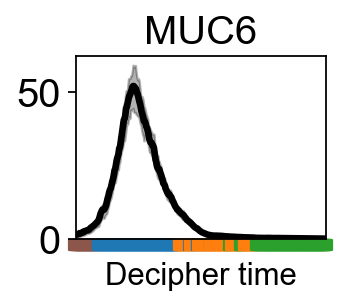

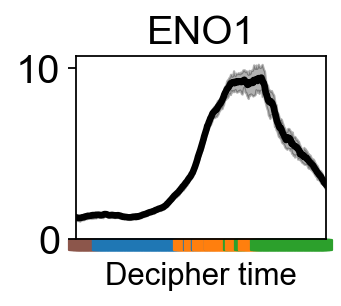

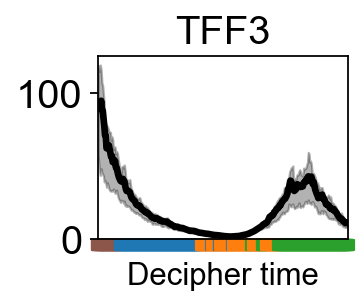

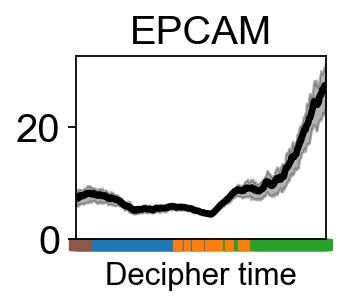

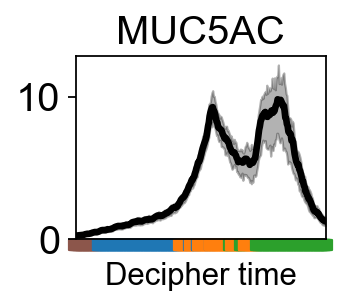

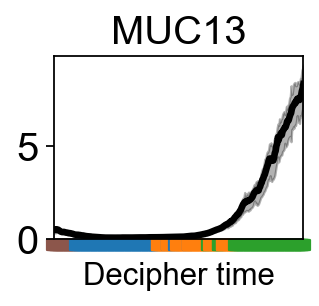

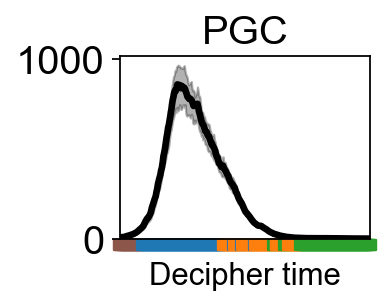

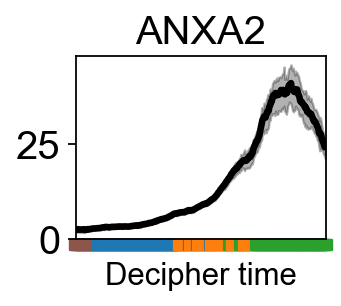

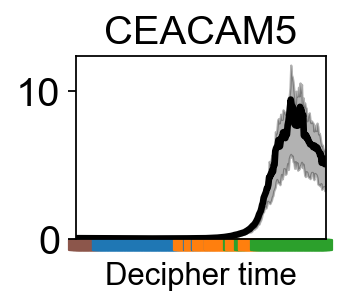

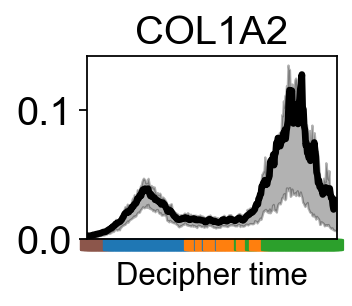

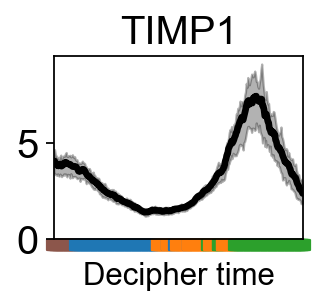

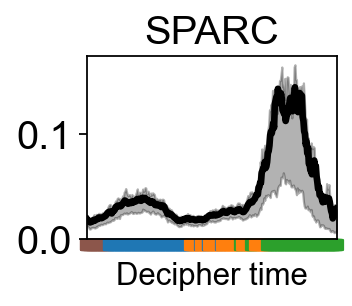

In [160]:

for g in marker_genes:
    
    plot_gene_patterns(g, adata, trajectory, gene_patterns, "black", figsize=[2,1.5])
    add_cell_type_band(trajectory, palette=gastric_palette)
    plt.ylabel("")
    plt.savefig(f"figures/figure5/gastric.patterns/{g}.pdf", bbox_inches="tight")

## UMAP

In [156]:
adata_pca = sc.pp.log1p(adata, copy=True)
sc.pp.pca(adata_pca)
sc.pp.neighbors(adata_pca,)
sc.tl.umap(adata_pca)



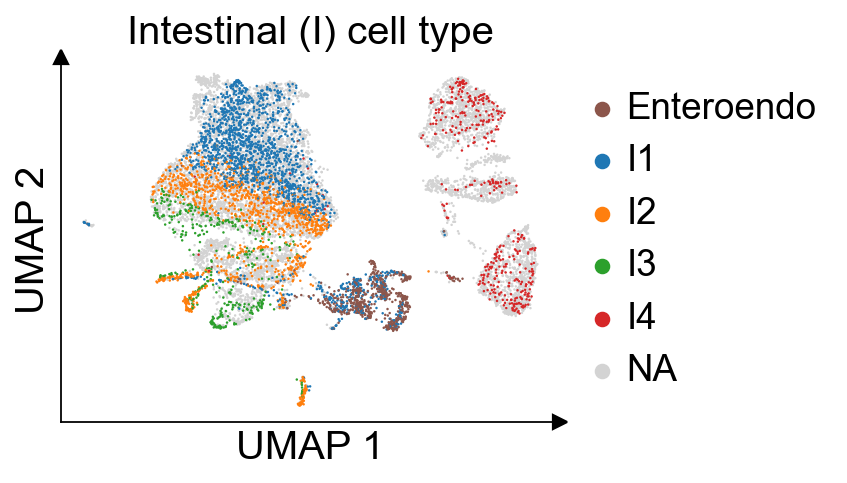

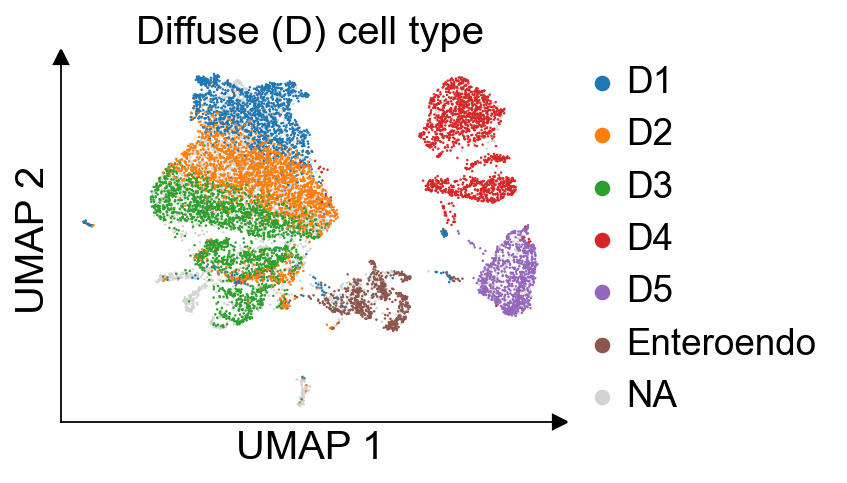

In [157]:
plot_decipher_v(
    adata_pca,
    "class_I",
    figsize=(4, 3),
    title="Intestinal (I) cell type",
    size=5,
    palette=gastric_palette,
    basis="X_umap",
    x_label="UMAP 1",
    y_label="UMAP 2",
)
plt.savefig("figures/figure5/gastric.umap.type_I.pdf", bbox_inches="tight")
plot_decipher_v(
    adata_pca,
    "class_D",
    figsize=(4, 3),
    title="Diffuse (D) cell type",
    size=5,
    palette=gastric_palette,
    basis="X_umap",
    x_label="UMAP 1",
    y_label="UMAP 2",
)
plt.savefig("figures/figure5/gastric.umap.type_D.pdf", bbox_inches="tight")